# ML for Gold Ore Extraction: #

## Introduction ##
The goal of this project is to prepare a ML prototype capable of predicting the amount of gold extracted from gold ore. Provided the data on extraction and purification.

Will need to perform the following steps:

1) Data Preprocessing:
- Exploratory Data Analysis (EDA)
- Whether or not the target variable/s have been calculated correctly and the features not available in the test set
- Handle missing/duplicate values.

2) Data Analysis:
- Comparing concentrations of metal in each purification stage
- Comparing feed particle size distributions in each dataset
- Checking for anomalies in the distribution of concentrations for each substance.

3) Model Training and Testing
- Creating custom functions to calculate sMAPE metric and final sMAPE metric determining hyperparameters for most accurate predictions.
- Model training and testing 
- Hyperparameter tuning and final testing and analysis 

4) Conclusions

In [1]:
#loading necessary libraries 
import pandas as pd 
import numpy as np 
from collections import defaultdict
from matplotlib import pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [2]:
gold_recovery_train = pd.read_csv("/Users/micha/gold-ore-extraction/datasets/gold_recovery_full.csv")
gold_recovery_test = pd.read_csv('/Users/micha/gold-ore-extraction/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/Users/micha/gold-ore-extraction/datasets/gold_recovery_full.csv')

In [10]:
gold_recovery_train.head(1)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


In [11]:
gold_recovery_test.head(1)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414


In [12]:
gold_recovery_full.head(1)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


In [13]:
#comparing recovery and making sure it was calculated correctly with given formula
recovery = gold_recovery_train.dropna(subset=[
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au',
    'rougher.output.recovery'
])
c = recovery['rougher.output.concentrate_au']
f = recovery['rougher.input.feed_au']
t = recovery['rougher.output.tail_au']
valid = (f != 0) & (c != 0)

recovery_calculation = (c[valid] * (f[valid] - t[valid])) / (f[valid] * (c[valid] - t[valid])) * 100
current_recovery = recovery.loc[valid, 'rougher.output.recovery']
mae = mean_absolute_error(current_recovery, recovery_calculation)

print(f"Mean Absolute Error (MAE) between calculated and current rougher recovery: {mae:.7f}")

Mean Absolute Error (MAE) between calculated and current rougher recovery: 0.0000000


### Conclusions on Recovery Formula: ###
Verified the 'rougher.output.recovery' feature (target) by recalculating with the given formula; (c[valid] * (f[valid] - t[valid])) / (f[valid] * (c[valid] - t[valid])) * 100, after running this calculation checked the MAE, which was equal to 0.0 confirming that the feature was calculated correctly.

In [19]:
#checking features within each dataframe and seeing what is not in the test set
set_1 = set(gold_recovery_train.columns)
set_2 = set(gold_recovery_test.columns)
set_3 = set(gold_recovery_full.columns)

missing_in_test_but_in_train = set_1 - set_2
print("\nFeatures in Train Set but Missing in Test")
print(sorted(missing_in_test_but_in_train))

missing_in_test_but_in_full = set_3 - set_2
print("\nFeatures in Full Set but Missing in Test:")
print(sorted(missing_in_test_but_in_full))

print(f"\nMissing features match: {missing_in_test_but_in_train == missing_in_test_but_in_full}")


Features in Train Set but Missing in Test
['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'ro

In [20]:
#making the above output more readable
missing_features = missing_in_test_but_in_full
grouped = defaultdict(list)
for feature in sorted(missing_features):
    prefix = feature.split('.')[0]
    grouped[prefix].append(feature)

for stage in sorted(grouped):
    print(f"\n{stage.upper()} features missing in test set:")
    for feature in sorted(grouped[stage]):
        print(f" - {feature}")


FINAL features missing in test set:
 - final.output.concentrate_ag
 - final.output.concentrate_au
 - final.output.concentrate_pb
 - final.output.concentrate_sol
 - final.output.recovery
 - final.output.tail_ag
 - final.output.tail_au
 - final.output.tail_pb
 - final.output.tail_sol

PRIMARY_CLEANER features missing in test set:
 - primary_cleaner.output.concentrate_ag
 - primary_cleaner.output.concentrate_au
 - primary_cleaner.output.concentrate_pb
 - primary_cleaner.output.concentrate_sol
 - primary_cleaner.output.tail_ag
 - primary_cleaner.output.tail_au
 - primary_cleaner.output.tail_pb
 - primary_cleaner.output.tail_sol

ROUGHER features missing in test set:
 - rougher.calculation.au_pb_ratio
 - rougher.calculation.floatbank10_sulfate_to_au_feed
 - rougher.calculation.floatbank11_sulfate_to_au_feed
 - rougher.calculation.sulfate_to_au_concentrate
 - rougher.output.concentrate_ag
 - rougher.output.concentrate_au
 - rougher.output.concentrate_pb
 - rougher.output.concentrate_sol
 - 

### Conclusions for Features Missing From Test Set: ###
After comparing the test set to the training and full datasets there are 34 columns (identical in full and training sets) that are missing features from the test set. Fall into 4 main categories:   
- 'final.output.*'
- 'primary_cleaner.output.*'
- 'rougher.output.*'and 'rougher.calculation.'
- 'secondary_cleaner.output.*'

These columns represent:
- Target Variables (e.g. rougher.output.recovery, final.output.recovery) or,
- Post-process outputs such as concentrate/tail compositions and metrics that are from or dependent on target values
  
These were left out intentionally and appropriately for prepping the test dataset for final evaluation. These features would not be available to the model/s in a real-world environment here predictions must be made before recovery results or gold content is known. Including these features would lead to data leakage (info not available at production time -- is used to train the model, leads to overly optimistic performance during training and validation but poor performance in real world simulations) inflating model perfomance and making model inaccurate. Making sure that only valid, preprocessing input features are included means we maintain model accuracy and accurately reflect how the model would operate in a real world setting. 

## Data Preprocessing: ##

In [21]:
#dropping the features from 'train' and 'full' datasets not found in the test set 
train_features_to_drop = missing_in_test_but_in_train - {'rougher.output.recovery', 'final.output.recovery'}
full_features_to_drop = missing_in_test_but_in_full - {'rougher.output.recovery', 'final.output.recovery'}

gold_recovery_train_cleaned = gold_recovery_train.drop(columns=train_features_to_drop)
gold_recovery_full_cleaned = gold_recovery_full.drop(columns=full_features_to_drop)

#checking the shape of the cleaned dataframes
print("Train Shape:", gold_recovery_train_cleaned.shape)
print("Full Shape:", gold_recovery_full_cleaned.shape)

Train Shape: (22716, 55)
Full Shape: (22716, 55)


In [22]:
#defining 'dfs' and 'df_names'
dfs = [gold_recovery_train_cleaned, gold_recovery_test, gold_recovery_full_cleaned]
df_names = ['gold_recovery_train_cleaned', 'gold_recovery_test', 'gold_recovery_full_cleaned']

for df, name in zip(dfs, df_names):
    print(f'Missing Values for {name}\n')
    print(df.isna().sum())
    print('-' * 125)

Missing Values for gold_recovery_train_cleaned

date                                             0
final.output.recovery                         1963
primary_cleaner.input.sulfate                 1609
primary_cleaner.input.depressant              1546
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                1151
primary_cleaner.state.floatbank8_a_air          56
primary_cleaner.state.floatbank8_a_level        49
primary_cleaner.state.floatbank8_b_air          56
primary_cleaner.state.floatbank8_b_level        43
primary_cleaner.state.floatbank8_c_air          54
primary_cleaner.state.floatbank8_c_level        43
primary_cleaner.state.floatbank8_d_air          55
primary_cleaner.state.floatbank8_d_level        43
rougher.input.feed_ag                           98
rougher.input.feed_pb                          244
rougher.input.feed_rate                        553
rougher.input.feed_size                        439
rougher.input.feed_sol            

In [51]:
#Checking the % of missing values.
for df, name in zip(dfs, df_names):
    mis_values = df.isnull().sum().to_frame('missing_values')
    mis_values['%'] = round(df.isnull().sum()/len(df),3)
    print(f'\n==={name}===')
    print(mis_values.sort_values(by='%', ascending=False))


===gold_recovery_train_cleaned===
                                            missing_values      %
rougher.output.recovery                               2573  0.153
rougher.input.floatbank11_xanthate                    1904  0.113
final.output.recovery                                 1521  0.090
primary_cleaner.input.sulfate                         1307  0.078
primary_cleaner.input.depressant                      1262  0.075
rougher.input.floatbank10_sulfate                     1044  0.062
primary_cleaner.input.xanthate                         985  0.058
rougher.input.floatbank11_sulfate                      623  0.037
rougher.state.floatbank10_e_air                        603  0.036
rougher.input.feed_rate                                513  0.030
rougher.input.feed_size                                417  0.025
secondary_cleaner.state.floatbank2_a_air               363  0.022
rougher.input.floatbank10_xanthate                     346  0.021
rougher.input.feed_sol                   

In [23]:
for df, name in zip(dfs, df_names):
    print(f'Info for {name}\n')
    print(df.info())
    print('-' * 125)

Info for gold_recovery_train_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        22716 non-null  object 
 1   final.output.recovery                       20753 non-null  float64
 2   primary_cleaner.input.sulfate               21107 non-null  float64
 3   primary_cleaner.input.depressant            21170 non-null  float64
 4   primary_cleaner.input.feed_size             22716 non-null  float64
 5   primary_cleaner.input.xanthate              21565 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      22660 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    22667 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      22660 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    2

In [24]:
#checking for duplicates
for df, name in zip(dfs, df_names):
    print(f'Duplicates for {name}\n')
    print(df.duplicated().sum())
    print('-' * 125)

Duplicates for gold_recovery_train_cleaned

0
-----------------------------------------------------------------------------------------------------------------------------
Duplicates for gold_recovery_test

0
-----------------------------------------------------------------------------------------------------------------------------
Duplicates for gold_recovery_full_cleaned

0
-----------------------------------------------------------------------------------------------------------------------------


In [25]:
#redifining dfs dictionary
dfs = {
    'gold_recovery_train_cleaned': gold_recovery_train_cleaned,
    'gold_recovery_test': gold_recovery_test,
    'gold_recovery_full_cleaned': gold_recovery_full_cleaned

}
#converted all the 'date' column to 'datetime64' datatype
for name, df in dfs.items():
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print(f"After Converting to DateTime: {df['date'].dtype}")
    print(f"==={name}===")
    print(f"First 3 Dates:\n{df['date'].head(3)}")

After Converting to DateTime: datetime64[ns]
===gold_recovery_train_cleaned===
First 3 Dates:
0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
Name: date, dtype: datetime64[ns]
After Converting to DateTime: datetime64[ns]
===gold_recovery_test===
First 3 Dates:
0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
Name: date, dtype: datetime64[ns]
After Converting to DateTime: datetime64[ns]
===gold_recovery_full_cleaned===
First 3 Dates:
0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
Name: date, dtype: datetime64[ns]


In [26]:
#using interpolate to fill in the missing values in the columns
dfs = {
    'gold_recovery_train_cleaned': gold_recovery_train_cleaned,
    'gold_recovery_test': gold_recovery_test,
    'gold_recovery_full_cleaned': gold_recovery_full_cleaned
}
for name, df in dfs.items():
    if df.index.name != 'date':
        df.set_index('date', inplace=True)
    dfs[name] = df.interpolate(method='time', inplace=True)
    df.reset_index(inplace=True)
    missing_count = df.isna().sum()
    print(f"\nAfter Interpolating Missing Values in {name} dataset:\n{'-' * 80}\n{missing_count}")
    dfs[name] = df


After Interpolating Missing Values in gold_recovery_train_cleaned dataset:
--------------------------------------------------------------------------------
date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size    

In [27]:
#redefining the 'dfs' and 'df_names' variables
dfs = [gold_recovery_train_cleaned, gold_recovery_test, gold_recovery_full_cleaned]
df_names = ['gold_recovery_train_cleaned', 'gold_recovery_test', 'gold_recovery_full_cleaned']
#checking info to ensure missing values have been successfully interpolated
for df, name in zip(dfs, df_names):
    print(f'Info for {name}\n')
    print(df.info())
    print('-' * 125)

Info for gold_recovery_train_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        22716 non-null  datetime64[ns]
 1   final.output.recovery                       22716 non-null  float64       
 2   primary_cleaner.input.sulfate               22716 non-null  float64       
 3   primary_cleaner.input.depressant            22716 non-null  float64       
 4   primary_cleaner.input.feed_size             22716 non-null  float64       
 5   primary_cleaner.input.xanthate              22716 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      22716 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    22716 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_air      2271

### Data Preprocessing Conclusions: ###
Dropped all the features that are missing from the test set from the train and full dataset although kept the necessary target variables 'rougher.output.recovery', 'final.output.recovery' for necessary model training. With the remaining columns opted to use time based interpolation to fill in the missing values as the index is in datetime format which estimates missing values based on time progression. Data is indexed by time and mining/processing features are typically collected over continuous (changes are gradual and not random) this method of filling missing values makes used of that gradual changeto fill missing values more intelligently than the mean or median. Also the % of missing values per dataset is not extremely large and should not skew/affect the data regardless of the missing values being filled in.

## Data Analysis: ##

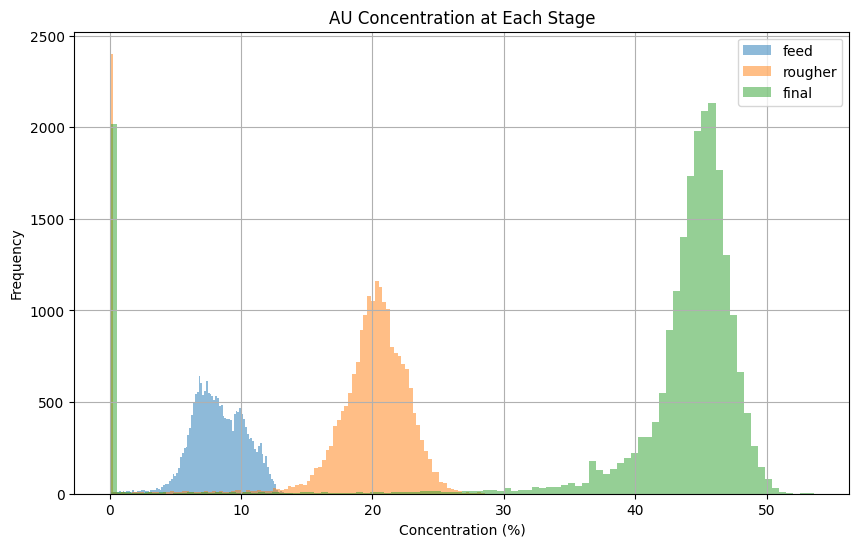

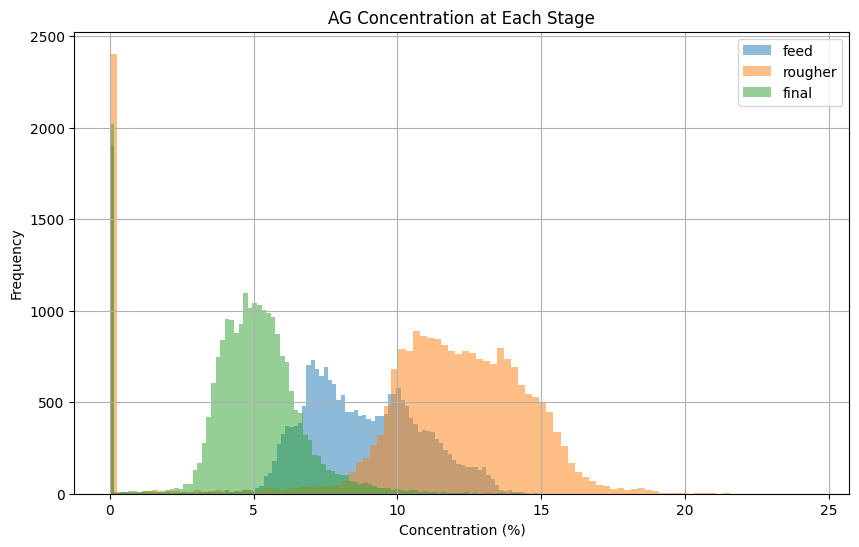

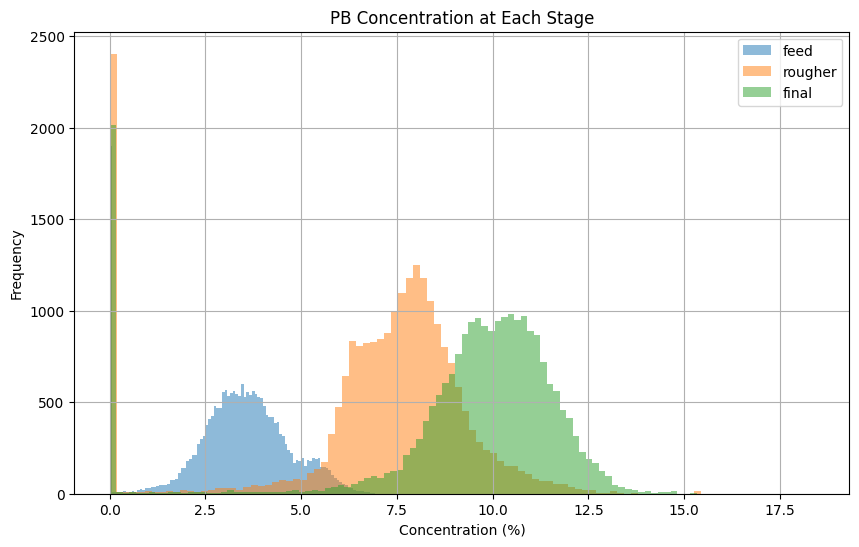

In [29]:
# checking the concentrations at each stage of gold, silver and lead 
metals = ['au', 'ag', 'pb']
stages = {
    'feed': 'rougher.input.feed_{}',
    'rougher': 'rougher.output.concentrate_{}',
    'final': 'final.output.concentrate_{}'
}
for metal in metals: 
    plt.figure(figsize=(10, 6))
    for stage, col_pattern in stages.items():
        col = col_pattern.format(metal)
        #used original 'gold_recovery_full' dataset containing all data that was dropped for model training
        if col in gold_recovery_full.columns: 
            gold_recovery_full[col].plot(kind='hist', alpha=0.5, label=stage, bins=100)
    plt.title(f'{metal.upper()} Concentration at Each Stage')
    plt.xlabel('Concentration (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

### Conclusions On Gold, Silver and Lead Concentrations in Different Purification Stages: ###
From the above histograms (disregarding values close to 0) we can see that the concentration of gold increases the most from feed to final stages (after all this is what the company is after) there was not much overlap in each stage with the least amount present during feed, then the rougher stage and the most present in the final stage. Silver is distributed differently with the lowest concentration in the final stage, then the feed stage and highest concentrated in the rougher stage of purification. Lead is distributed similar to gold but in a much lower concentration the feed stage has the lowest concentration, the rougher stage is the next highest and the final stage has the highest concentration of lead. However even though lead and gold have the most similar distributions the final concentration of lead ranges mostly from 5 to 12.5% whereas gold ranges roughly from 30 to 50% concentration meaning the company is achieving their goal of collecting the highest possible gold concentration.

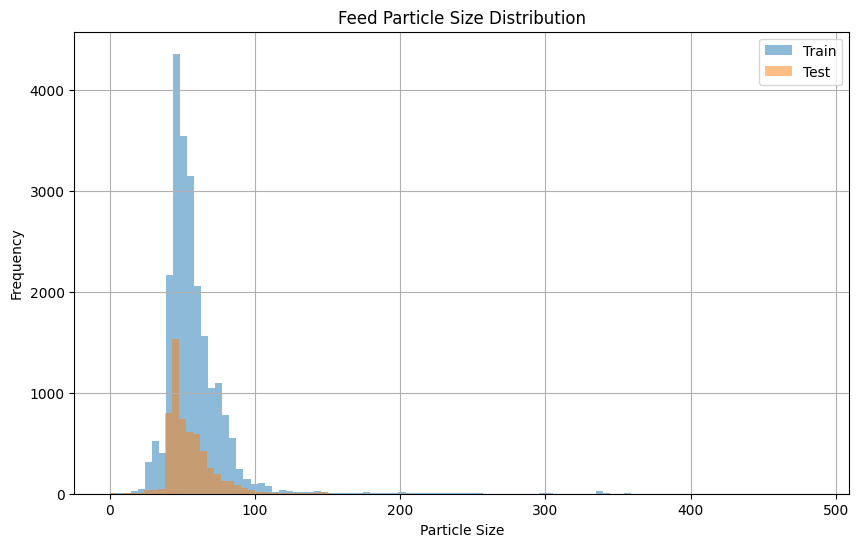

Train Feed Description:
 count    22716.000000
mean        58.310834
std         25.332276
min          0.046369
25%         46.655412
50%         53.325305
75%         64.209362
max        484.967466
Name: rougher.input.feed_size, dtype: float64
Test Feed Description:
 count    5856.000000
mean       55.886800
std        22.704970
min         0.046369
25%        43.865121
50%        49.964796
75%        61.615634
max       477.445473
Name: rougher.input.feed_size, dtype: float64


In [30]:
# checking feed particle size distribution between train and test set
train_feed_size = gold_recovery_train_cleaned['rougher.input.feed_size']
test_feed_size = gold_recovery_test['rougher.input.feed_size']

plt.figure(figsize=(10, 6))
train_feed_size.plot(kind='hist', bins=100, alpha=0.5, label='Train')
test_feed_size.plot(kind='hist', bins=100, alpha=0.5, label='Test')
plt.title('Feed Particle Size Distribution')
plt.xlabel('Particle Size')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

print("Train Feed Description:\n", train_feed_size.describe())
print("Test Feed Description:\n", test_feed_size.describe())

### Conclusions on Feed Particle Size Distribution between Test and Training Sets: ###
Distributions between the 2 are generally consistent so model evaluation should be valid. There are some things to take note of, the mean of the test set is lower probably because of more small particles being, there is also a very low minimum value in the test set could be a data entry error or outlier and may need to be removed to improve model quality and reduce noise. 

### **Conclusions for Data Analysis and Next Steps:** ## 
**Conclusions:**

When analysing and observing the concentrations for each metal in each stage of purification (feed, rougher and final) in the total distributions there seems to be a disproportionate amount of values at or very close to 0, which may skew analysis and are not helpful to model predictions (as the company is looking for the most mineral rich deposits/ore). Silver and lead are lower concentrated which makes sense as they are not the target mineral. Lead and gold are the most similarly distributed with silver being the least prevalent in the final stage of purification. Also when observing the feed stage for the test and the training set there are some low value outliers in the test set which may create noise and decrease model quality. 

**Next Steps:** 

For the purpose of model training and removing outliers that may skew data have opted to drop the values at or very close to 0 in the training and full dataset, there rows contain either erroneous or uninformative data, models trained on rows with unrealisticc or undesirable concentrations might learn patterns outside of purification process and hurts learning ability. The test set however we'll leave untouched with the exception of the 'rougher.input.feed_size' feature which is not a target but a numerical feature, low values here will create unecessary noise and may mess with model behaviour. 

In [31]:
#dropping the extremely low values from 'train' and 'full' datasets
threshold = 1.0
total_metal_train = gold_recovery_train_cleaned[['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb']].sum(axis=1)
total_metal_full = gold_recovery_full_cleaned[['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb']].sum(axis=1)

train = gold_recovery_train_cleaned[total_metal_train > threshold]
full = gold_recovery_full_cleaned[total_metal_full > threshold]
#dropping rows with extremely small feed size for all 3 datasets 
train = train[train['rougher.input.feed_size'] > 5]
test = gold_recovery_test[gold_recovery_test['rougher.input.feed_size'] > 5]
full = full[full['rougher.input.feed_size'] > 5]

## Building The Model: ##

In [32]:
#creating a function to calculate 'sMAPE' and final sMAPE value
def smape(true, pred):
    return np.mean(2 * np.abs(true - pred) / (np.abs(true) + np.abs(pred))) * 100

def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [33]:
#splitting the data and adding 'rougher.output.recovery' & 'final.output.recovery' to test set
train_rougher = train['rougher.output.recovery']
train_final = train['final.output.recovery']
test_rougher = full['rougher.output.recovery'].reindex(test.index)
test_final = full['final.output.recovery'].reindex(test.index)
#ensuring indices are sorted
test = test.sort_index()
full = full.sort_index()
#dropping 'rougher.output.recovery' & 'final.output.recovery' from the training set 
train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [34]:
#confirming alignment to make sure indices match
common_index = test.index.intersection(full.index)
print(f"Matching Timestamps: {len(common_index)} out of {len(test.index)}")

Matching Timestamps: 5360 out of 5852


In [35]:
#checking missing values after using reindex and adding target variables to 'test_rougher' and 'test_final'
dfs = {
    'test_rougher': test_rougher,
    'test_final': test_final
}
for name, df in dfs.items():
    print(f"==={name}===")
    print(df.isna().sum())
    df.dropna(inplace=True)
    print(f"==={name} after dropping===")
    print(df.isna().sum())

===test_rougher===
492
===test_rougher after dropping===
0
===test_final===
492
===test_final after dropping===
0


**NOTE:**
Can see that the timestamps that do not match between the test and full datasets as a result of missing values created after using reindex on the 2 datasets. Needs to be addressed before moving forward did so in the above code.

In [36]:
#dropping datetime columns from train, test and full to allow for model training
train = train.select_dtypes(exclude=(['datetime64[ns]', 'datetime64']))
test = test.select_dtypes(exclude=(['datetime64[ns]', 'datetime64']))
full = full.select_dtypes(exclude=(['datetime64[ns]', 'datetime64']))

In [37]:
#model training and cross validation
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=246),
    'RandomForestRegressor': RandomForestRegressor(random_state=246)
}
#wrapping smape into a scorer
smape_scorer = make_scorer(smape, greater_is_better=False)
#cross validation
for name, model in models.items():
    print(f"\nModel: {name}")
    #cross validation for rougher and final target
    scores_rougher = cross_val_score(model, train, train_rougher, cv=3, scoring=smape_scorer, error_score='raise')
    scores_final = cross_val_score(model, train, train_final, cv=3, scoring=smape_scorer, error_score='raise')
    #inverting the negative sMAPE score
    smape_rougher = -scores_rougher.mean()
    smape_final = -scores_final.mean()
    combined_final_smape = final_smape(smape_rougher, smape_final)

    print(f"Rougher sMAPE: {smape_rougher}")
    print(f"Final sMAPE: {smape_final}")
    print(f"Combined final sMAPE: {combined_final_smape}")


Model: LinearRegression
Rougher sMAPE: 13.936037819151224
Final sMAPE: 15.219528067765134
Combined final sMAPE: 14.898655505611657

Model: DecisionTreeRegressor
Rougher sMAPE: 26.101526555982318
Final sMAPE: 22.750099162217094
Combined final sMAPE: 23.5879560106584

Model: RandomForestRegressor
Rougher sMAPE: 15.614850292609667
Final sMAPE: 14.11053040293499
Combined final sMAPE: 14.486610375353658


In [38]:
#using a parameter grid and GridSearchCV to find the best hyperparameters for the final model 
param_grid = {
    'n_estimators': [50],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}
grid_rougher = GridSearchCV(RandomForestRegressor(random_state=246), param_grid, scoring=smape_scorer, cv=3, n_jobs=-1)
grid_rougher.fit(train, train_rougher)
grid_final = GridSearchCV(RandomForestRegressor(random_state=246), param_grid, scoring=smape_scorer, cv=3, n_jobs=-1)
grid_final.fit(train, train_final)

print("Best Parameters for Rougher Model:")
print(grid_rougher.best_params_)
print(f"Best sMAPE Score: {-grid_rougher.best_score_}")
print("\nBest Parameters for Final Model:")
print(grid_final.best_params_)
print(f"Best sMAPE Score: {-grid_final.best_score_}")

Best Parameters for Rougher Model:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best sMAPE Score: 13.765956465627944

Best Parameters for Final Model:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best sMAPE Score: 13.495793194471887


In [39]:
best_parameters = {
    'n_estimators': 50,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'random_state': 246
}
best_rougher_model = RandomForestRegressor(**best_parameters)
best_final_model = RandomForestRegressor(**best_parameters)
#fitting the best model 
best_rougher_model.fit(train, train_rougher)
best_final_model.fit(train, train_final)
#running predictions on test data 
predictions_rougher = pd.Series(best_rougher_model.predict(test), index=test.index)
predictions_final = pd.Series(best_final_model.predict(test), index=test.index)

In [40]:
#getting final sMAPE score
smape_rougher = smape(test_rougher, predictions_rougher)
smape_final = smape(test_final, predictions_final)
best_final_score = final_smape(smape_rougher, smape_final)
print(f"Rougher sMAPE: {smape_rougher}")
print(f"Final sMAPE: {smape_final}")
print(f"Final sMAPE Score for Best Model: {best_final_score} ")

Rougher sMAPE: 20.427390737489116
Final sMAPE: 17.6453634314435
Final sMAPE Score for Best Model: 18.340870257954904 


## Overall Conclusions for Model Training and Testing: ##
. The aim of the model is to predict gold recovery efficiency during the recovery and final output stages in gold purification. Used the Symmetric Mean Absolute Percentage Error (sMAPE) with emphasis on the final recovery prediction over the rougher stage. After our data preprocessing and analysis and removing extremely low values from our final training data to ensure minimal noise when building the model, evaluated 3 different models (LinearRegression, RandomForestRegressor and DecisionTreeRegressor) it was clear that the RandomForestRegressor had the most positive results in training and cross validation optimised hyperparameters with 'GridSearchCV' and the best performing model acheived around 17% for both stages (Rougher, Final and the combined sMAPE score of both). This shows the model performs reasonably well and generalises effectively to unseen data particulary in final recovery, model provides reliable recovery predictions that support company decision making. 